In [2]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
transformers.__version__

'4.30.2'

## 1. summary
- attention mechanism
- encoder vs decoder
    - seq2seq
        - seq of tokens(input) => seq of tokens(output)
    - tasks
        - machine translation
    - encoder
        - seq of tokens => seq of embedding
    - decoder
        - encoder's hidden state => seq of tokens
        - interatively generate
            - until the EOF or length limit
            - one token at a time

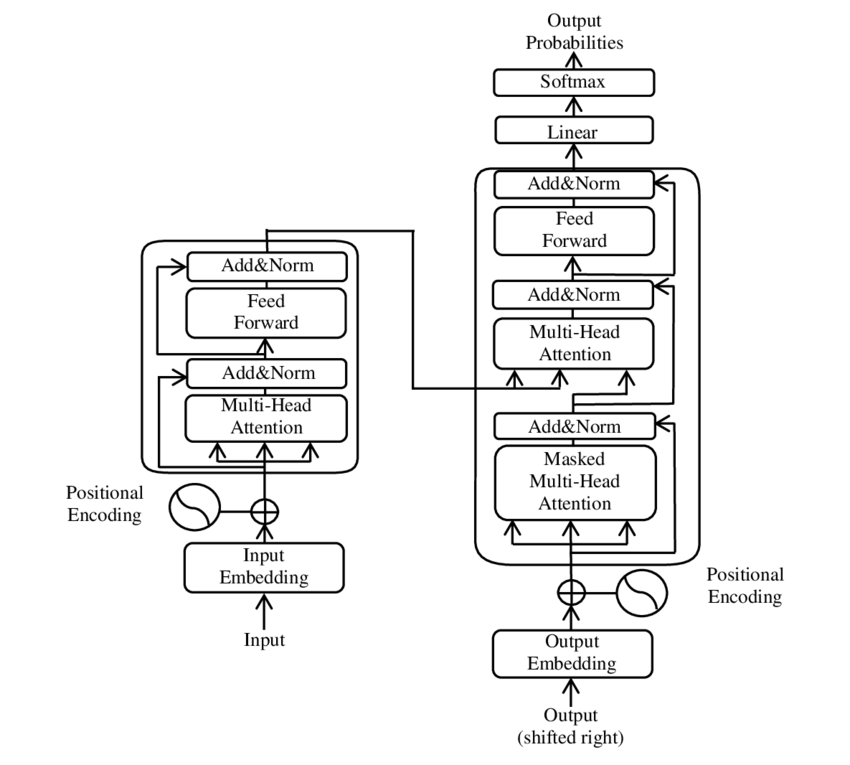

In [4]:
from IPython.display import Image

Image('../image/The-Transformer-model-architecture.png')

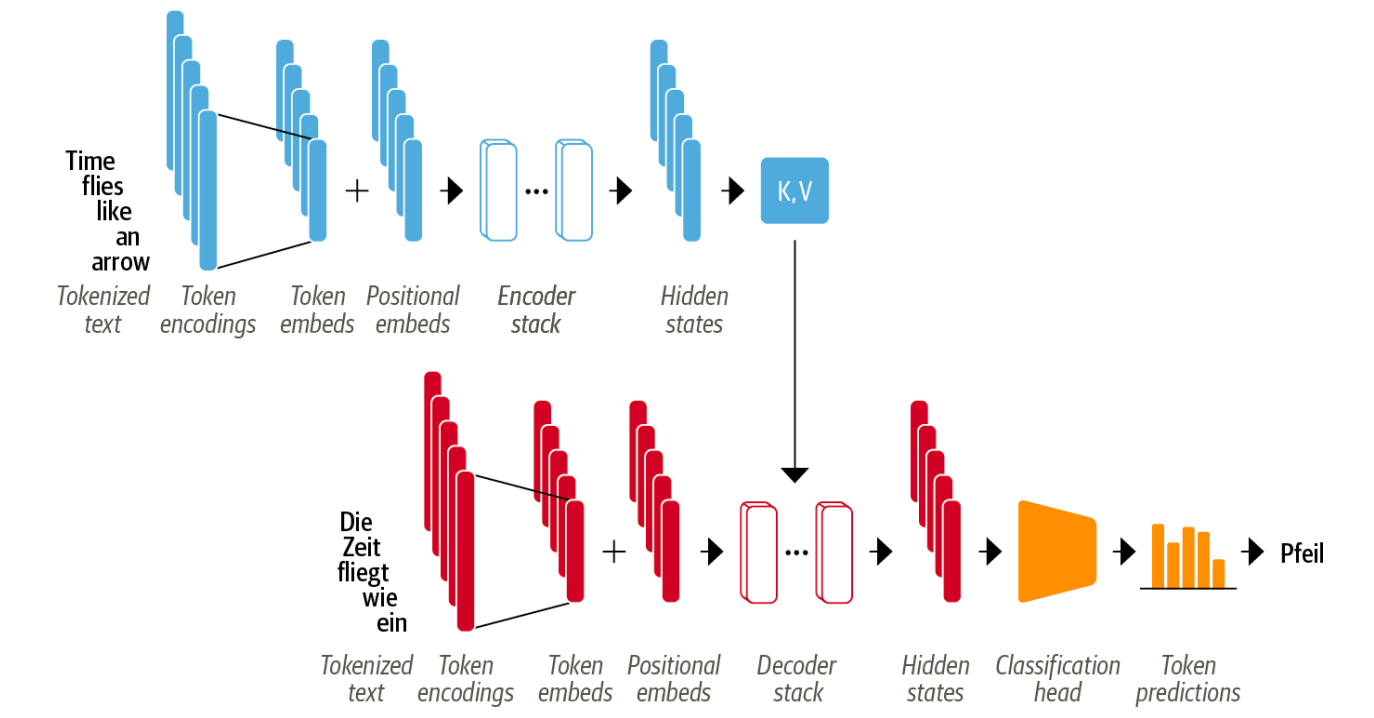

In [5]:
Image('../image/encoder-decoder.png')

- encoder only: seq of text => rich representation(bidirectional attention)
    - task
        - text classification
        - NER
    - models
        - BERT
        - RoBerta
        - distillBert
    - 完形填空
        - representation of a given token depends both on
            - left (before of the token)
            - after (after the token)
- decoder only: 
    - gpt
    - 词语接龙
        - representation of a given token depends only on the left
- encoder and decoder both
    - tasks
        - machine translation
        - summarization
    - model
        - T5
        - bart

## 2. encoder(encoder layer stack)
- encoder layer: encoding the contextual information
    - input: seq of embeddings
        - mulit-head self attention
        - mlp
    - ouput: 
        - same shape of input
    - contextual information(contextualized embeddings)
        - apple: company-like or fruit-like
        - flies
            - time flies like arrow: soar
            - fruit flies like a banana: insect
    - skip connection(residue) & layer normalization

#### 2.1 multi-head self attention

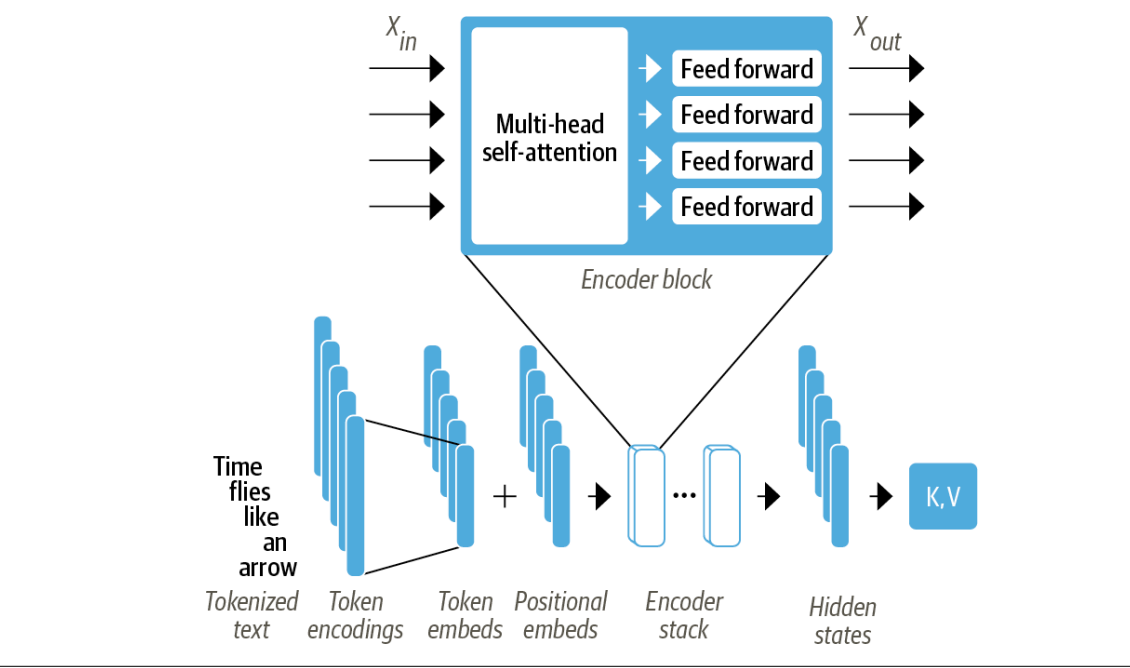

In [6]:
Image('../image/encoder-layer.png')

#### 2.1.1 self attention
- each token
    - 不是fixed embedding
    - 而是weighted average of each embedding of the whole input sequence
    - a sequence of token $x_1,x_2,...,x_n$
    - $ x_i^t = \sum_{j=1}^{n}w_{ji}x_j$

#### 2.1.2 scaled dot-product attention

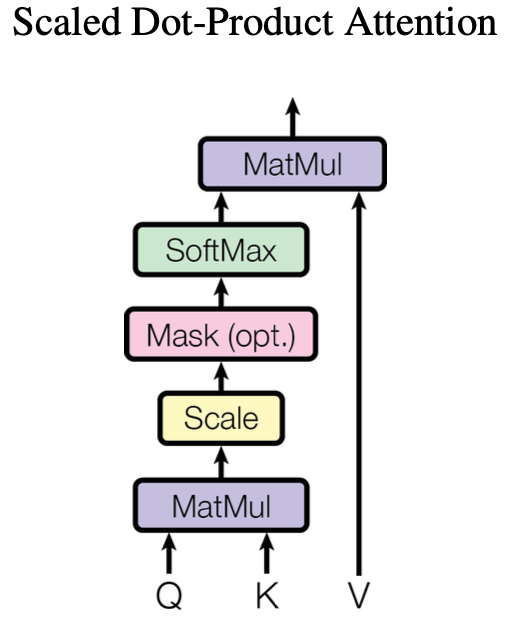

In [7]:
Image('../image/scaled-dot-attn-img.png')

$$
\mathcal Attention(Q,K,V) = \mathcal softmax(\frac{QK_{T}}{\sqrt{d_k}})V
$$

#### 2.1.3 visualization analysis

In [9]:
!pip install bertviz

In [11]:
from transformers import AutoTokenizer
model_name = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_name)
# model

from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

In [12]:
sample_text = "time flies like an arrow"
show(model,model_type='bert',tokenizer=tokenizer,sentence_a=sample_text,display_mode='light',layer=0,head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

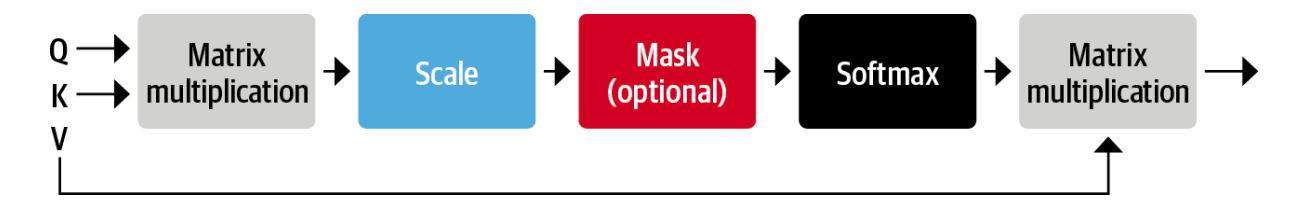

In [13]:
Image('../image/qkv.png')

- 来源于信息检索
    - information retrieve system

#### 2.1.4 compute self attention

In [14]:
model_inputs = tokenizer(sample_text,return_tensors='pt',add_special_tokens=False)
model_inputs

{'input_ids': tensor([[ 2051, 10029,  2066,  2019,  8612]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [15]:
from torch import nn
from transformers import AutoConfig

In [16]:
config = AutoConfig.from_pretrained(model_name)
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [17]:
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
token_embedding

Embedding(30522, 768)

In [19]:
input_embeddings = token_embedding(model_inputs['input_ids'])
input_embeddings

tensor([[[ 1.5665,  0.7637,  0.0488,  ..., -0.4440,  0.1076,  0.0816],
         [ 0.3600, -0.3716,  0.7174,  ...,  0.1746, -0.2119,  0.6970],
         [-0.9084,  0.3790, -0.6734,  ..., -1.2851,  0.3262,  1.2301],
         [ 0.5354, -0.4607,  0.5515,  ..., -0.4435,  0.1572,  0.5222],
         [ 1.2288,  0.6635, -0.4238,  ..., -0.5359,  0.0657, -0.8093]]],
       grad_fn=<EmbeddingBackward0>)

In [23]:
query = key = value = input_embeddings
dim_k = key.size(-1)

attn_scores = torch.bmm(query,key.transpose(1,2)) /np.sqrt(dim_k)

attn_scores.shape

torch.Size([1, 5, 5])

In [25]:
import torch.nn.functional as F

attn_weights = F.softmax(attn_scores,dim=-1)
attn_weights.shape

torch.Size([1, 5, 5])

In [26]:
attn_weights.sum(axis=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [28]:
attn_outputs = torch.bmm(attn_weights,value)
attn_outputs.shape

torch.Size([1, 5, 768])

#### 2.1.5 multi-head (self/cross) attention

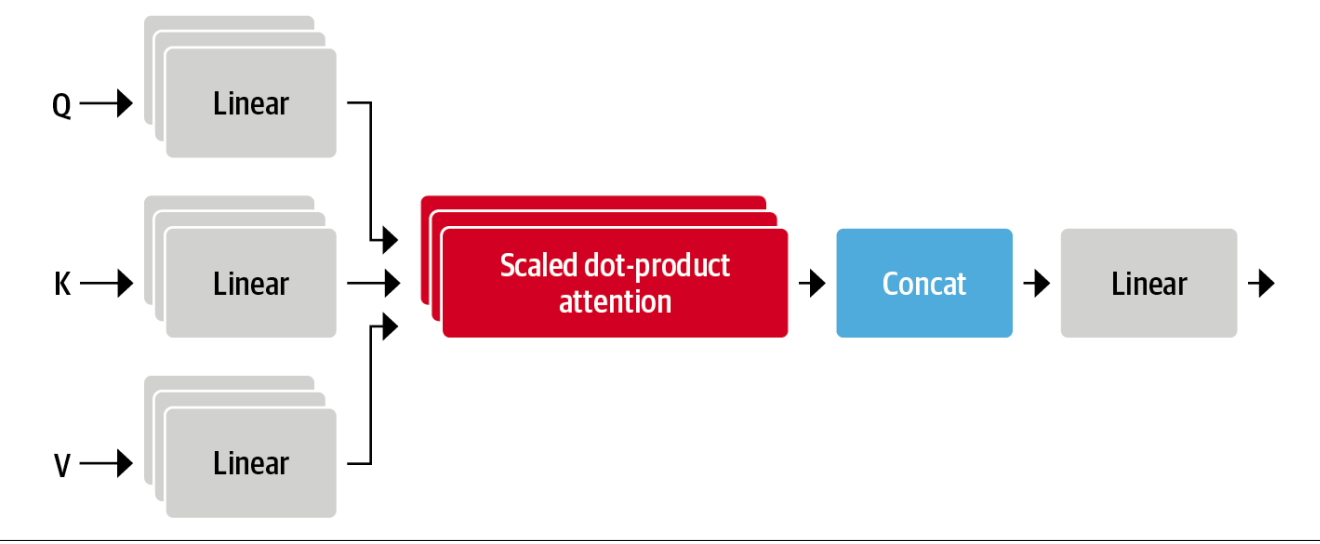

In [29]:
Image('../image/mha.png')

In [30]:
def scaled_dot_product_attention(query,key,value):
    dim_k = key.size(-1)
    attn_scores = torch.bmm(query,key.transpose(1,2)/np.sqrt(dim_k))
    attn_weights = F.softmax(attn_scores,dim=-1)
    return torch.bmm(attn_weights,value)

In [45]:
class Attentionhead(nn.Module):
    def __init__(self, embed_dim, head_dim) -> None:
        super().__init__()
        self.Wq = nn.Linear(embed_dim, head_dim)
        self.Wk = nn.Linear(embed_dim, head_dim)
        self.Wv = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_states):
        q = self.Wq(hidden_states)
        k = self.Wk(hidden_states)
        v = self.Wv(hidden_states)
        return scaled_dot_product_attention(q, k, v)

In [46]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim//num_heads
        # self.heads = nn.ModuleList(
        #     [Attentionhead(embed_dim, head_dim) for _ in range(num_heads)]
        # )
        self.heads = nn.ModuleList([
            Attentionhead(embed_dim, head_dim) for _ in range(num_heads)
        ])
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        print(f"hidden_state shape:{hidden_state.shape}")
        print(f'head(hidden_state): {self.heads[11](hidden_state).shape}')
        x = torch.cat([head(hidden_state) for head in self.heads], dim=-1)
        print(f'cat heads: {x.shape}')
        x = self.output_layer(x)
        return x

In [47]:
from torch import nn
from transformers import AutoConfig,AutoTokenizer,AutoModel

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

In [48]:
mha = MultiHeadAttention(config)

In [49]:
mha(input_embeddings) 

hidden_state shape:torch.Size([1, 5, 768])
head(hidden_state): torch.Size([1, 5, 64])
cat heads: torch.Size([1, 5, 768])


tensor([[[-0.0642,  0.0777,  0.1105,  ...,  0.1059,  0.1308, -0.0932],
         [-0.0486,  0.1438,  0.0872,  ...,  0.1716,  0.2097, -0.0475],
         [-0.0871,  0.1024,  0.1498,  ...,  0.0709,  0.1897, -0.1053],
         [-0.1442,  0.1720,  0.0142,  ...,  0.1509,  0.1607, -0.2006],
         [-0.0626,  0.0571,  0.1634,  ...,  0.0819,  0.1576, -0.1018]]],
       grad_fn=<ViewBackward0>)

In [52]:
from bertviz import head_view
from transformers import AutoModel
model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)
sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"
viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
# nsp (next sentence prediction)
print(viz_inputs)
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
print(sentence_b_start)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])
head_view(attention, tokens, sentence_b_start, heads=[8])